In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

from hydracv.fluorescence import trace_fluo
from hydracv.utils import utils

import cv2
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from skimage.restoration import denoise_wavelet

In [3]:
# Load warped video

FILEPATH = '/home/hengji/Data/hydracv/hydracv/data/videos/warped/'
FILENAME = 'cb1_warp_adjusted.avi'
vidcap = cv2.VideoCapture(FILEPATH + FILENAME)
success,image = vidcap.read()
count = 0

# Crop setting
x_start = 100
x_end = 300
y_start = 250
y_end = 450

nrow = x_end - x_start
ncol = y_end - y_start

# Load frames
frames = []

while success:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[x_start:x_end, y_start:y_end]
    frames.append(image)
    success, image = vidcap.read()

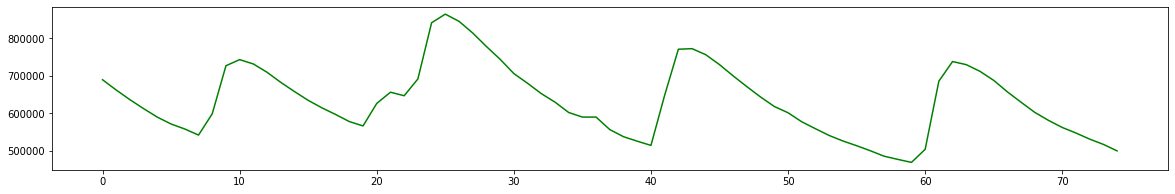

In [4]:
# Total fluorescence
fluo = trace_fluo.trace(FILEPATH + FILENAME, display=False)
plt.figure(figsize=(20,3))
plt.plot(fluo, 'g')
plt.show()

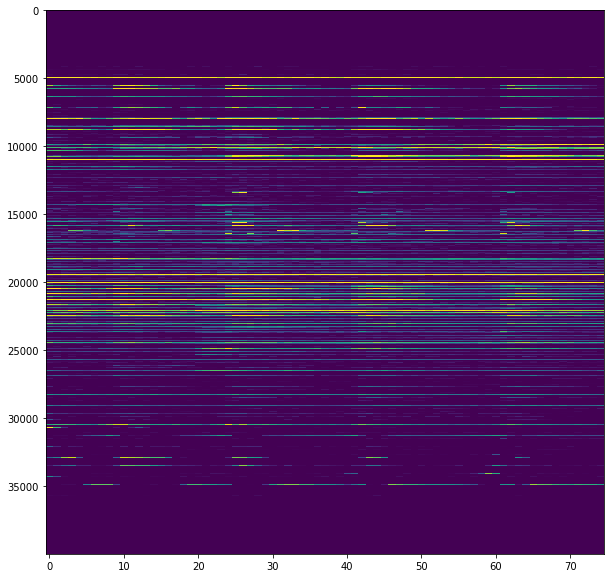

In [5]:
# Reformat frames

frames = np.array(frames)
frames = np.reshape(frames, (len(frames), -1)).T

orig_frames = np.copy(frames)

plt.figure(figsize=(10,10))
plt.imshow(frames, aspect='auto')
plt.show()

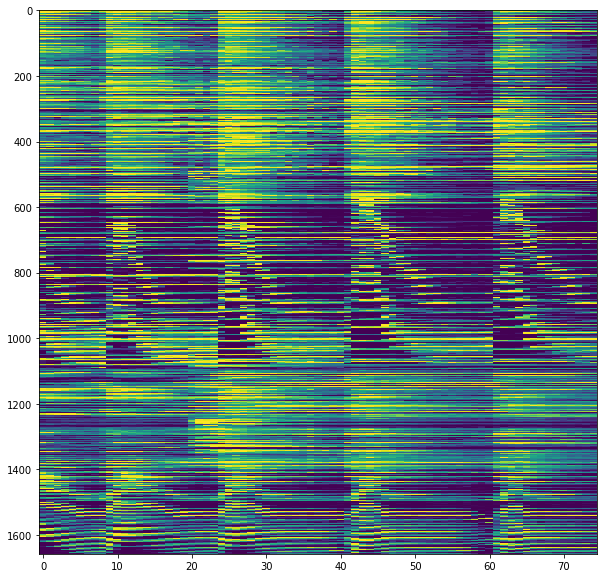

In [6]:
# Filter out low intensity ones

ind_dict = defaultdict(int)

filtered_frames = []
for orig_index, pixel in enumerate(orig_frames):
    if np.std(pixel) > 40:
        filtered_frames.append(pixel)
        ind_dict[len(filtered_frames)-1] = orig_index
filtered_frames = np.array(filtered_frames)
plt.figure(figsize=(10,10))
plt.imshow(filtered_frames, aspect='auto')
plt.show()

## Decomposition

### - NMF

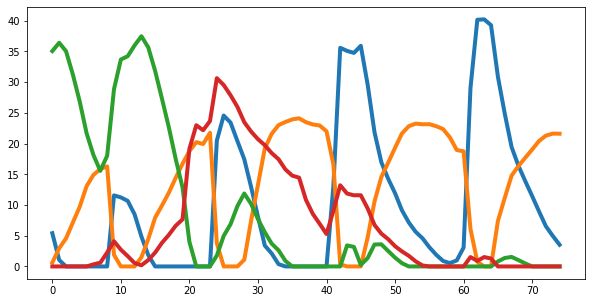

In [7]:
# # Process frames
# for i in range(len(frames)):
#     minv = min(frames[i])
#     frames[i] -= minv

model = NMF(n_components=4)
W = model.fit_transform(filtered_frames)
H = model.components_

plt.figure(figsize=(10,5))
plt.plot(H.T, linewidth=4)
plt.show()

### - PCA

In [8]:
# PCA

# Process frames
frames = np.zeros(filtered_frames.shape)
for i in range(len(filtered_frames)):
    pixel = filtered_frames[i]
    std = np.std(pixel)
    mean = np.mean(pixel)
    frames[i] = (pixel - mean) / std

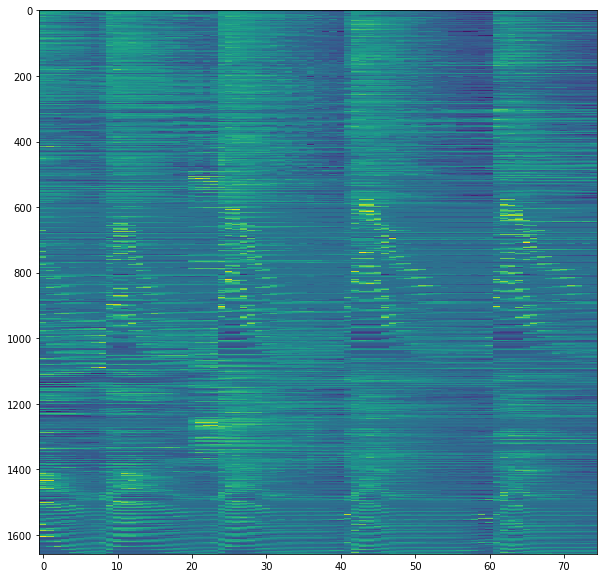

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(frames, aspect='auto')
plt.show()

In [10]:
pca = PCA(n_components=5, svd_solver='full')
pca.fit(frames)
U = pca.components_

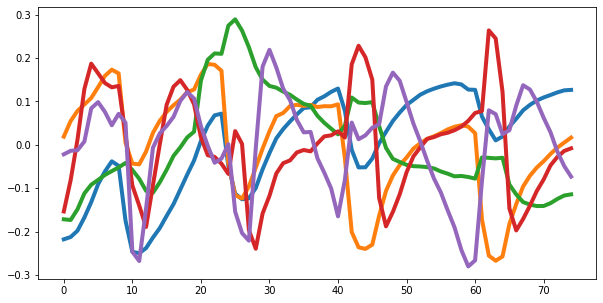

In [11]:
plt.figure(figsize=(10,5))
plt.plot(U.T, linewidth=4)
plt.show()

### - K-means on intensity

In [7]:
filtered_frames.shape

(1658, 75)

In [8]:
# Process frames
frames = np.zeros(filtered_frames.shape)
for i in range(len(filtered_frames)):
    track = filtered_frames[i]
    frames[i] = (track - min(track)) / (max(track) - min(track))

In [9]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(frames)

In [10]:
clusters = defaultdict(list)

for i in range(len(filtered_frames)):
    clusters[kmeans.labels_[i]].append(filtered_frames[i])

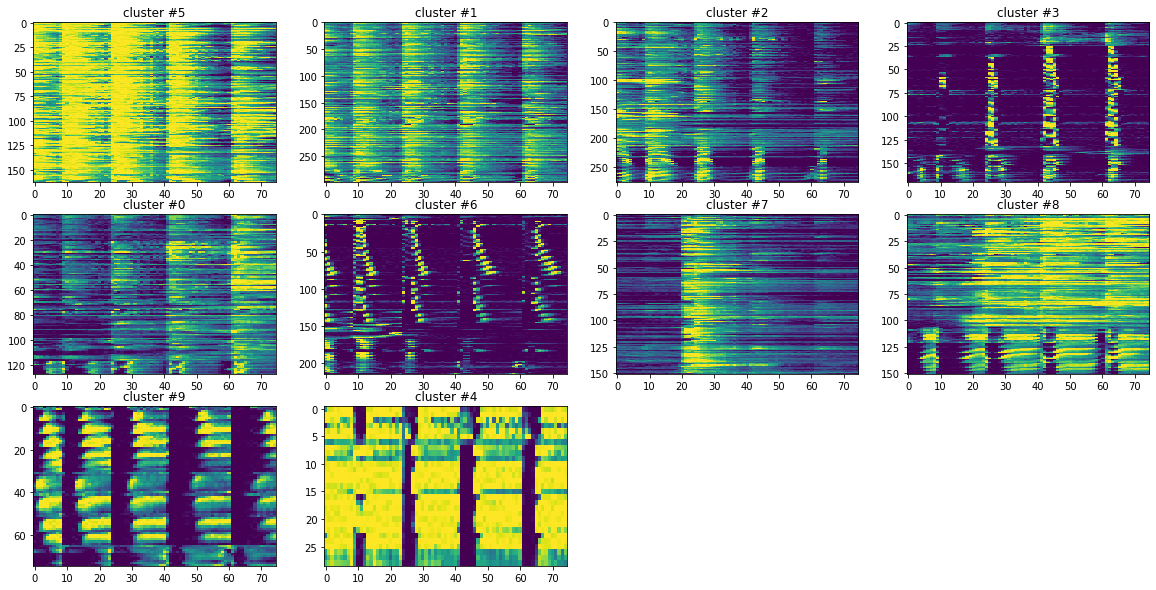

In [11]:
fig = plt.figure(figsize=(20,10))
n_row = int(np.sqrt(len(clusters)))
n_col = len(clusters) // n_row + 1
for i, cluster in enumerate(clusters):
    ax = fig.add_subplot(n_row, n_col, i+1)
    ax.imshow(np.array(clusters[cluster]), aspect='auto')
    ax.set_title('cluster #' + str(cluster))
plt.show()

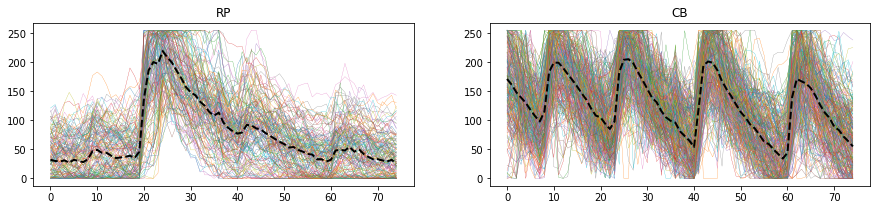

In [24]:
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(121)
ax1.plot(np.array(clusters[7]).T, linewidth=0.25)
ax1.plot(np.median(clusters[7], 0), 'k--', linewidth=2)
ax1.set_title('RP')
ax2 = fig.add_subplot(122)
ax2.plot(np.array(clusters[1]).T, linewidth=0.25)
ax2.plot(np.median(clusters[1], 0), 'k--', linewidth=2)
ax2.set_title('CB')
plt.show()

### - Ensembles based on peaks (Thibault's pipeline)

In [13]:
# Denoise tracks

traces_denoised = []

for trace in filtered_frames:
    traces_denoised.append(denoise_wavelet(trace, multichannel=False, method='BayesShrink', mode='soft', rescale_sigma=True))
    
traces_denoised = np.array(traces_denoised)

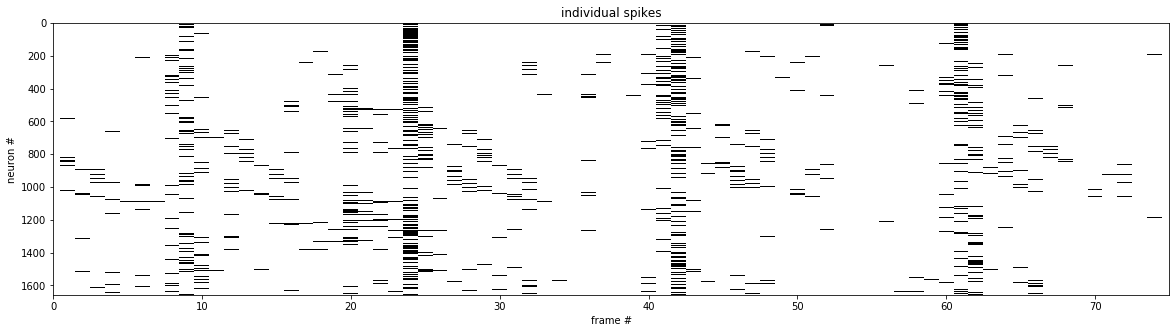

In [14]:
# Extract individual spikes

spikes = np.zeros(traces_denoised.shape)

for i, trace in enumerate(traces_denoised):
    deriv = [0]
    for j in range(1, traces_denoised.shape[1]):
        x = trace[j] - trace[j-1]
        if x > 0:
            deriv.append(x)
        else:
            deriv.append(0)
    deriv = np.array(deriv)
    nindex = int(sum(deriv > 0) * 0.2)
    if nindex == 0:
        continue
    else:
        ktopindex = sorted(deriv.argsort()[-nindex:])
        spikes[i][ktopindex] = 1

count_fire = np.sum(spikes, axis=0)
    
plt.figure(figsize=(20,5))
plt.imshow(spikes, aspect='auto', cmap='binary')
plt.xlim(0, len(count_fire))
plt.xlabel('frame #')
plt.ylabel('neuron #')
plt.title('individual spikes')
plt.show()

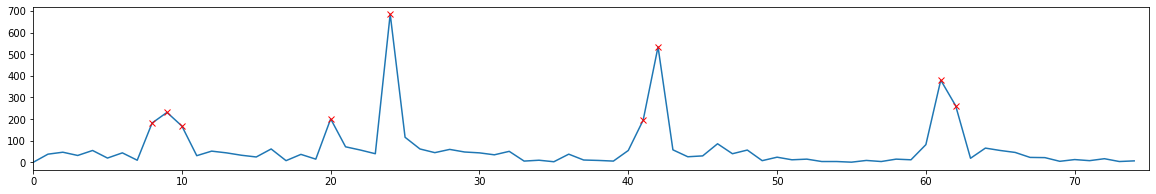

In [15]:
# Indentify peaks
nindex = int(len(count_fire) * 0.13)
peaks = sorted(count_fire.argsort()[-nindex:])
# wlen = 2

# peaks_ = [peaks[0]]
# for i in range(1, len(peaks)):
#     if peaks[i] - peaks[i-1] < wlen:
#         if count_fire[peaks[i]] < count_fire[peaks[i-1]]:
#             continue
#         else:
#             peaks_.pop()
#     peaks_.append(peaks[i])
# peaks = peaks_

plt.figure(figsize=(20,3))
plt.plot(count_fire)
plt.plot(peaks, count_fire[list(peaks)], 'rx')
plt.xlim(0, len(count_fire))
plt.show()

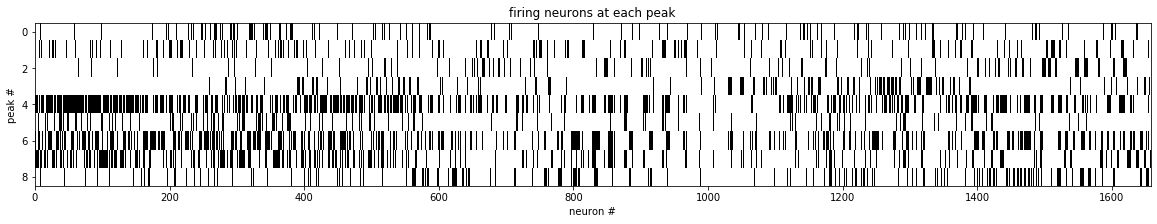

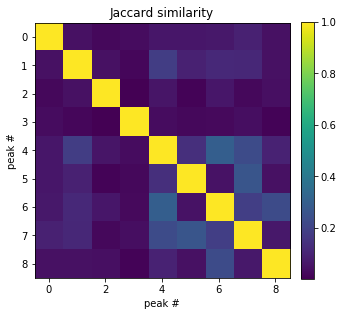

In [28]:
# Similarity between peaks

peak_vectors = []
for peak in peaks:
    vector = []
    for train in spikes:
        vector.append(train[peak])
    peak_vectors.append(vector)

peak_vectors = np.array(peak_vectors)

plt.figure(figsize=(20,3))
plt.imshow(peak_vectors, aspect='auto', cmap='binary')
plt.xlabel('neuron #')
plt.ylabel('peak #')
plt.title('firing neurons at each peak')
plt.show()

npeaks = len(peaks)
sim_mat = np.zeros((npeaks, npeaks))
for i in range(npeaks):
    for j in range(i, npeaks):
        sim_mat[i, j] = np.sum(peak_vectors[i] * peak_vectors[j]) / np.sum(peak_vectors[i] + peak_vectors[j] > 0)
        sim_mat[j, i] = sim_mat[i, j]

plt.figure(figsize=(5,5))
im = plt.imshow(sim_mat, aspect='equal')
plt.xlabel('peak #')
plt.ylabel('peak #')
plt.title('Jaccard similarity')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

In [26]:
# Cluster neuron ensembles
peak_ensemble1 = peaks[:3] + peaks[4:]
peak_ensemble2 = [peaks[3]]

cluster1 = []
cluster2 = []
for i, train in enumerate(spikes):
    count1 = 0
    for peak in peak_ensemble1:
        if train[peak] == 1:
            count1 += 1
            if count1 > 0.3 * len(peak_ensemble1):
                break
    if count1 > 0.3 * len(peak_ensemble1):
        cluster1.append(i)
        continue
        
    count2 = 0
    for peak in peak_ensemble2:
        if train[peak] == 1:
            count2 += 1
            if count2 > 0 * len(peak_ensemble2):
                break
    if count2 > 0 * len(peak_ensemble2):
        cluster2.append(i)

In [18]:
len(cluster2)

197

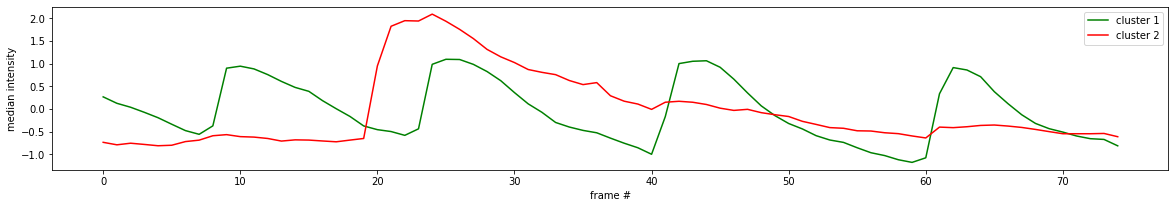

In [19]:
# Median fluorescence traces
traces = filtered_frames
traces1 = np.array([(traces[i] - np.mean(traces[i])) / np.std(traces[i]) for i in cluster1])
traces2 = np.array([(traces[i] - np.mean(traces[i])) / np.std(traces[i]) for i in cluster2])

plt.figure(figsize=(20,3))
plt.plot(np.median(traces1, axis=0), color='g', label='cluster 1')
plt.plot(np.median(traces2, axis=0), color='r', label='cluster 2')
plt.xlabel('frame #')
plt.ylabel('median intensity')
plt.legend()
plt.show()

## Locate Neurons

### - K-means clusters

In [20]:
# Construct neurons map
neuron_map = defaultdict(int)
for ind in ind_dict:
    if kmeans.labels_[ind] in (0, 1, 2, 5):
        neuron_map[ind_dict[ind]] = -1
    elif kmeans.labels_[ind] == 7:
        neuron_map[ind_dict[ind]] = -2
        
neuron_canvas = np.zeros(len(orig_frames))
for i in range(len(neuron_canvas)):
    if i in neuron_map:
        neuron_canvas[i] = neuron_map[i]
neuron_canvas = np.reshape(neuron_canvas, (nrow, ncol))

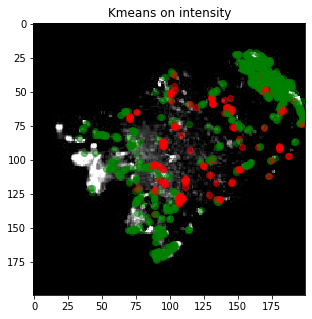

In [21]:
# Plot
plt.figure(figsize=(5,5))
plt.imshow(np.reshape(orig_frames[:, 0], (nrow, ncol)), cmap='gray')
for x in range(nrow):
    for y in range(ncol):
        if neuron_canvas[y][x] == -1:
            plt.plot(x, y, 'go', alpha=0.5)
        elif neuron_canvas[y][x] == -2:
            plt.plot(x, y, 'ro', alpha=0.5)
plt.title('Kmeans on intensity')
plt.show()

### - Clusters of Thibault's pipeline

In [22]:
# Construct neurons map
neuron_map = defaultdict(int)
for ind in ind_dict:
    if ind in cluster1:
        neuron_map[ind_dict[ind]] = -1
    elif ind in cluster2:
        neuron_map[ind_dict[ind]] = -2
        
neuron_canvas = np.zeros(len(orig_frames))
for i in range(len(neuron_canvas)):
    if i in neuron_map:
        neuron_canvas[i] = neuron_map[i]
neuron_canvas = np.reshape(neuron_canvas, (nrow, ncol))

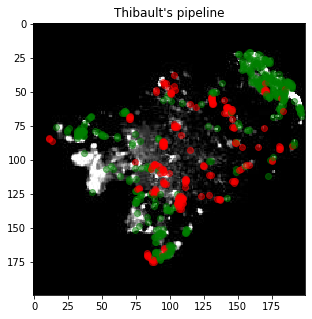

In [23]:
# Plot
plt.figure(figsize=(5,5))
plt.imshow(np.reshape(orig_frames[:, 0], (nrow, ncol)), cmap='gray')
for x in range(nrow):
    for y in range(ncol):
        if neuron_canvas[y][x] == -1:
            plt.plot(x, y, 'go', alpha=0.5)
        elif neuron_canvas[y][x] == -2:
            plt.plot(x, y, 'ro', alpha=0.5)
plt.title("Thibault's pipeline")
plt.show()

### - Reconstruct from NMF modes